# Data Cleaning and Exploratory Data Analysis

This notebook will clean our scraped coffee data, and explore relevant features. We will also utilize Latent Dirichlet Allocation (LDA) as unsupervised model to examine observed topics.

In [48]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text  import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('white')
sns.set_palette('Set3')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

# Read in data 

In [49]:
df = pd.read_csv('../data/coffee.csv')
#use slug as unique index id
df['slug'] = df['slug'].map(lambda x: x[8:])
df.set_index('slug', inplace=True)
#remove duplicate descriptions
df = df.drop_duplicates('desc_1')
#convert review_date to datetime column
df['review_date'] = pd.to_datetime(df['review_date'])
df.head()

,all_text,name,rating,roaster,region_africa_arabia,region_caribbean,region_central_america,region_hawaii,region_asia_pacific,region_south_america,...,aroma,acid,body,flavor,aftertaste,with_milk,desc_1,desc_2,desc_3,desc_4
slug,,,,,,,,,,,,,,,,,,,,,
ethiopia-deri-kochoha-2,\n\n\n\n \n93\nFlight Coffee Co.\nEthiopia Der...,Ethiopia Deri Kochoha,93,Flight Coffee Co.,1,0,0,0,0,0,...,9.0,8.0,9.0,9.0,8.0,NaN,"Bright, crisp, sweetly tart. Citrus medley, ca...",From the Deri Kochoha mill in the Hagere Marya...,A poised and melodic wet-processed Ethiopia co...,NaN
espresso-14,\n\n\n\n\n91\nDoi Chaang Coffee\nEspresso\nLoc...,Espresso,91,Doi Chaang Coffee,0,0,0,0,1,0,...,8.0,NaN,8.0,8.0,8.0,9.0,"Evaluated as espresso. Deeply rich, sweetly ro...",Doi Chaang is a single-estate coffee produced ...,"A rich, resonant espresso from Thailand, espec...",NaN
kenya-ruthaka-peaberry,\n\n\n\n \n95\nTemple Coffee and Tea\nKenya Ru...,Kenya Ruthaka Peaberry,95,Temple Coffee and Tea,1,0,0,0,0,0,...,9.0,8.0,9.0,10.0,8.0,NaN,"Deeply sweet, richly savory. Dark chocolate, p...",Despite challenges ranging from contested gove...,"A high-toned, nuanced Kenya cup, classic in it...",NaN
ethiopia-gora-kone-sidamo,\n\n\n\n \n93\nTemple Coffee and Tea\nEthiopia...,Ethiopia Gora Kone Sidamo,93,Temple Coffee and Tea,1,0,0,0,0,0,...,9.0,8.0,9.0,9.0,8.0,NaN,"Fruit-forward, richly chocolaty. Raspberry cou...",Southern Ethiopia coffees like this one are la...,"A playful, unrestrained fruit bomb of a coffee...",NaN
specialty-coffee-blend-espresso,\n\n\n\n\n93\nChoosy Gourmet\nSpecialty Coffee...,Specialty Coffee Blend Espresso,93,Choosy Gourmet,0,0,0,0,0,0,...,9.0,NaN,8.0,9.0,8.0,9.0,"Evaluated as espresso. Rich, chocolaty, sweetl...",A blend of coffees from Ethiopia (natural-proc...,An espresso blend in which spice notes — in pa...,NaN


In [50]:
df.shape[0]

5118

 - 5118 unique observations (includes missing values)

In [51]:
df['text'] = df['desc_1']+df['desc_3'].fillna('')+df['desc_4'].fillna('')

 - Combined text of each coffee's description
 - Ignoring `desc_2` text: This represents the `Notes:` section of each coffee's description. The text in this section details the roasting method or notes on the roaster, irrelevant to the individual coffee's description and to our final recommending system.

## Latent Dirichlet Allocation

Preprocessing text data of coffee's descriptions for EDA. The following block of code prepares the text for natural language processing.

In [52]:
#instatiate tokenizer, and stemmer
tokenizer = RegexpTokenizer('\w+')
p_stemmer = PorterStemmer()

#create set of stopwords from sklearn and add more words
stops = set(stopwords.words('english'))

#add more stop words, uninformative of the coffee, and taster's names
more_stops = ['cup', 'cupper', 'cupping','reviewer','one','two','three','four',
              'co','taster','review', 'panel','panelist','rating', 'others', 'found',
              'nominating','reader','writes', 'ken', 'kenneth', 'davids', 'ron','walters',
              'kim','westerman', 'jason','sarley','jen', 'apodaca', 'ted','lingle', 
              'teri','bolla', 'willem','boot','ethan','hill','peggy','sue', 'martin', 'freeman', 
              'andrey', 'akselrod', 'heather', 'perry', 'byron', 'holcomb','andy', 'newbom', 
              'sean', 'kohmescher', 'john','diruocco', 'carolina', 'facciani', 'schulz', 
              'john', 'outler', 'monique', 'tam', 'woodard', 'springstube', 'dowling',
              'des', 'cabigan', 'christopher', 'losa', 'robert', 'bobbs', 'al', 'welker',
              'jennifer','stone']
for w in more_stops:
    stops.add(w)

#function to clean text
def to_words(raw_text):
    #remove numbers
    raw_text = re.sub('\d+', '', raw_text)
    #tokenize
    words = tokenizer.tokenize(raw_text.lower())
    #remove stop words and stem
    meaningful_words = [p_stemmer.stem(w) for w in words if not w in stops]

    return (" ".join(meaningful_words))

# Initialize empty lists to hold the clean texts.
clean_text = []

# Append clean texts to list.
for t in df['text']:
    clean_text.append(to_words(t))

#add column of clean text
df['clean_text'] = clean_text

### CountVectorizer 

 - Instatiate CountVectorizer with n-gram range of (2,2)
 - Fit LDA model with 5 topics

In [53]:
cv = CountVectorizer(min_df=2, ngram_range=(2,2))
text_cv = cv.fit_transform(clean_text)
df_cv = pd.DataFrame(text_cv.toarray(), columns = cv.get_feature_names())

In [54]:
lda = LatentDirichletAllocation(5, random_state=42)
lda.fit(df_cv);

#### Function to visualize LDA topics (adapted from [Dave Yerrington](https://www.linkedin.com/in/davidyerrington/)):

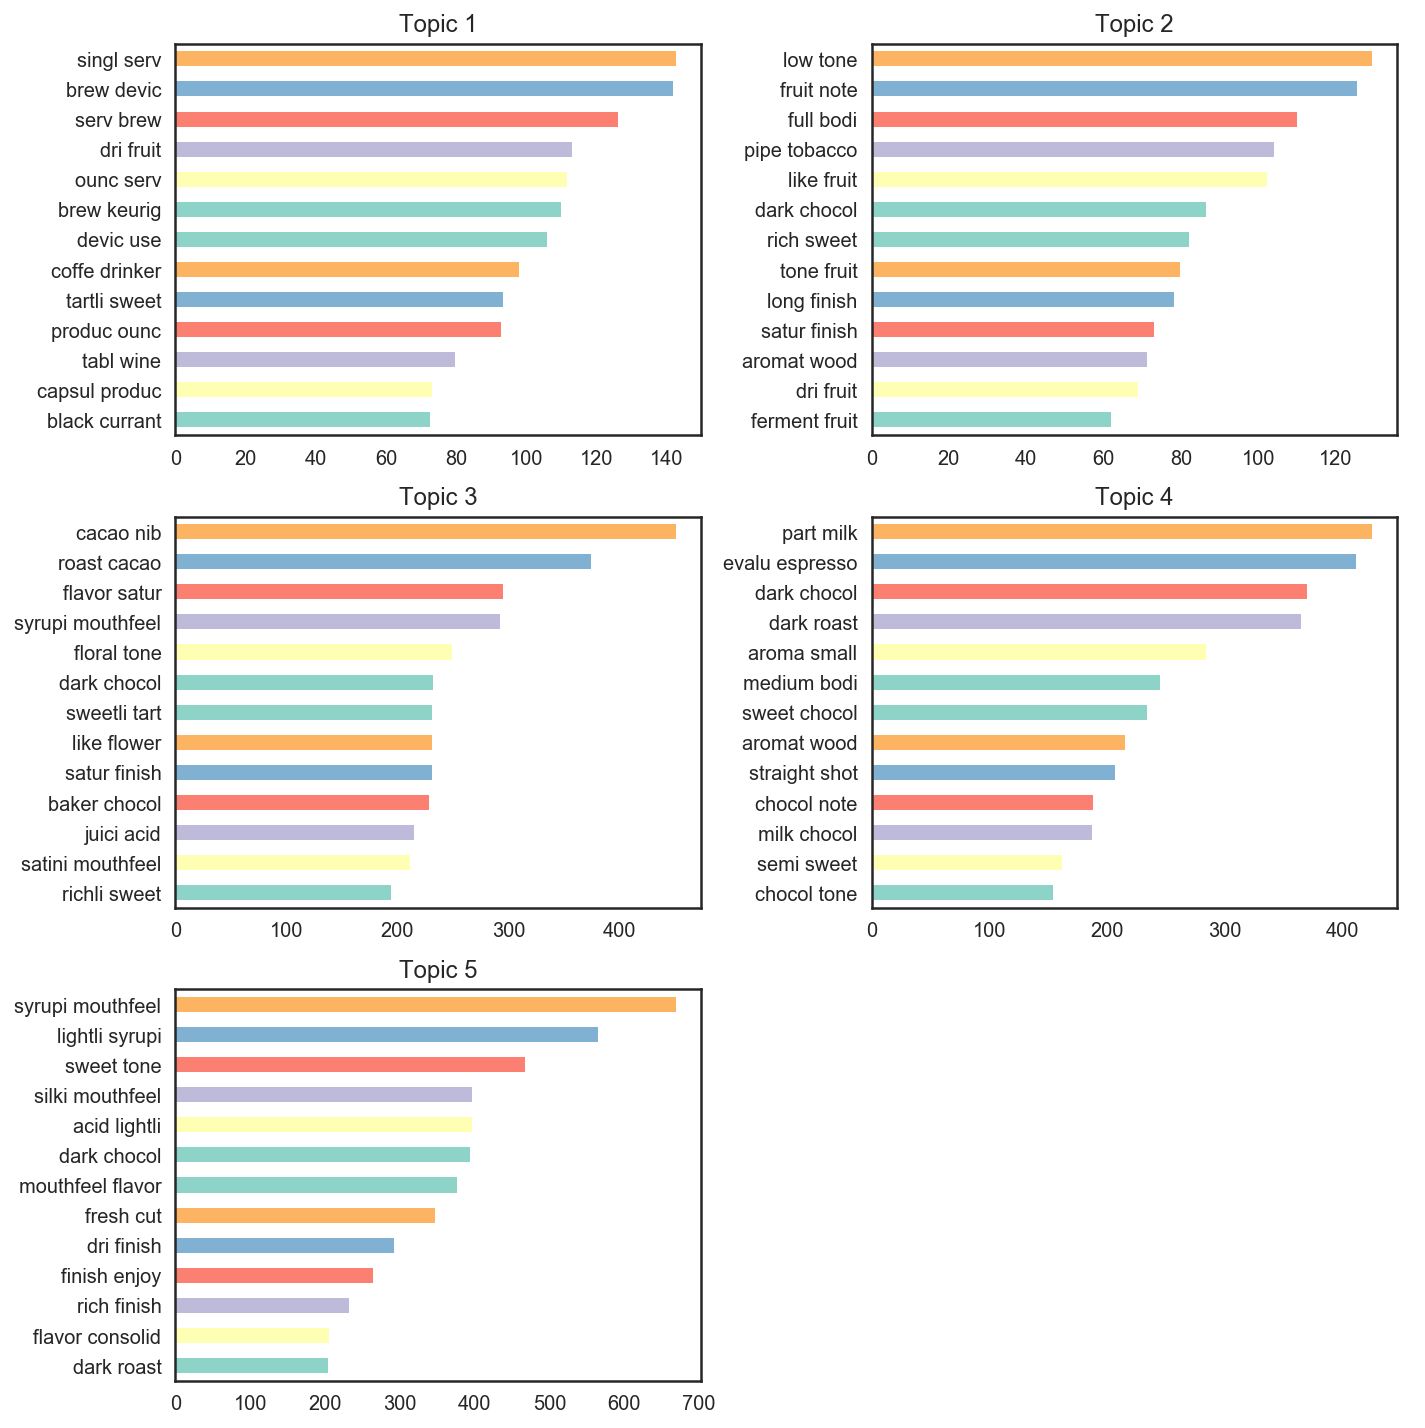

In [55]:
def display_topics(model, feature_names, no_words = 10):
    topics_tokens = []
    
    #count number of words in each topic
    for topic_idx, topic in enumerate(model.components_):
        topic = zip(feature_names, topic)
        topic = sorted(topic, key = lambda pair: pair[1])
        topic_words = [(token, counts) for token, counts in topic[:-no_words - 1:-1]]
        topics_tokens.append(topic_words)
    
    #iterate through topic tokens and chart each topic
    fig, ax = plt.subplots(figsize=(10, 10), nrows=3, ncols=2)
    topics = [{key: value for key, value in topic} 
            for topic in topics_tokens]

    row = 0
    for topic_id, topic in enumerate(topics):
        column = (0 if topic_id % 2 == 0 else 1)
        chart = pd.DataFrame([topic]).iloc[0].sort_values(axis=0)
        chart.plot(kind="barh", title= f"Topic {topic_id +1}", ax=ax[row, column])
        row += 1 if column == 1 else 0
    

display_topics(lda, cv.get_feature_names(), no_words=13)

#hide empty subplot
ax = plt.subplot(3,2,6)
ax.axis('off')
plt.tight_layout()

#### LDA allows us to visualize the words that may be associated with each potential topic. 
 - After testing many different numbers for topics and n-gram ranges, we settle on 5 topics baesd on 2-gram word count vectors and interpret potential topic as such:
     1. K-Cup/Pods/Capsule coffees
     2. Fruity flavored coffees
     3. Chocolate flavored coffees
     4. Espressos and Lattes
     5. Coffees with a distinct mouthfeel/texture
 - Previous values for topics and n-grams allowed us to find noise words to include in our set of stop words and helped determine whether to stem or lemmatize our text.

## Exploration and Cleaning

In [56]:
# display all columns how much data is missing in each column
df.isnull().sum()

all_text                     0
name                         0
rating                       0
roaster                      0
region_africa_arabia         0
region_caribbean             0
region_central_america       0
region_hawaii                0
region_asia_pacific          0
region_south_america         0
type_espresso                0
type_organic                 0
type_fair_trade              0
type_decaffeinated           0
type_pod_capsule             0
type_blend                   0
type_estate                  0
location                     2
origin                     591
roast                      424
est_price                 2105
review_date                  0
agtron                       0
aroma                       39
acid                       868
body                        13
flavor                      18
aftertaste                1008
with_milk                 4418
desc_1                       0
desc_2                       0
desc_3                    4147
desc_4  

#### Moving forward, we will not consider the following features:
- Location: location of the coffee's roaster, which doesn't affect final recommendations
- Origin: text string that can essentially be replaced with 7 binary `region_` columns
- Estimated Price: includes too many missing values, various currencies, and range over a long period of time (considering inflation rates). The price of each coffee does not affect our final recommendations
- Review Date: Although a coffee may have been reviewed as far back as 1997 and may no longer be available, we will still consider older coffees as their descriptions may be useful for NLP (building our dictionary/vocabulary).
- Agtron: Number range of Agtron Score before and after roasting. The Agtron is a scientific measurement of roast color. The specific number scale is not relevant for our recommendations, but can be inferred from the `Roast` level. More information on Agtron score [here](https://www.coffeereview.com/roast-definitions/).
- Aftertaste: According to the website, `aftertaste` is graded very similarly to `flavor`, but may not be graded for some coffees (1008 missing obervations); Instead of imputing these missing values, we can drop this column and focus on more important ratings.
- desc_3 (Notes): As stated earlier, this section of text describes the coffee's roaster and background not relevant for our recommendations. 

### The four most important ratings (score 1-10) to consider are: `aroma`, `body`, `flavor`, and `acid`.
Source: [Interpreting Reviews](https://www.coffeereview.com/interpret-coffee/)

In [57]:
df.dropna(subset=['aroma','body','flavor'], axis = 0, inplace= True)
df.shape[0]

5074

- Removed 44 observations with no `aroma`, `body`, or `flavor` ratings

In [58]:
#missing a value for acid or with_milk, but not both
df[df.acid.isnull() ^ df.with_milk.isnull()].shape[0]

4879

In [59]:
#value for both acid and with_milk exist
df[~df.acid.isnull() & ~df.with_milk.isnull()][['acid','with_milk']]

,acid,with_milk
slug,,
selian-tanzania-2,8.0,8.0
hawaii-puna-kazumura,5.0,5.0
kenya-5,8.0,8.0
costa-rica-el-conquistador,8.0,8.0
organic-espresso-blend-fair-trade,7.0,7.0
belo-espresso,7.0,7.0
black-flag-espresso,7.0,7.0
espresso-milano,9.0,9.0


In [60]:
df['acid_or_milk'] = df['acid'].fillna(df.with_milk)
df['type_with_milk'] = df['with_milk'].fillna(0).map(lambda x: 1 if x > 0 else 0)

In [61]:
df.acid_or_milk.isnull().sum()

187

In [62]:
df = df.dropna(subset=['acid_or_milk'],axis=0)

- We observe 667 missing values for `acid`.  
- We note for the 4870 observations where these values are missing, there is a reciprocal value in the `with_milk` column.
- For the 8 observations where there is a value for both, both values are the exact same!
- Therefore, missing `acid` values are filled in with `with_milk` values and changed to represent `acid_or_milk` (ew?)
- A binary column `type_with_milk` is created to signify this imputation.
- The remaining 187 observations where these values are still missing are removed.

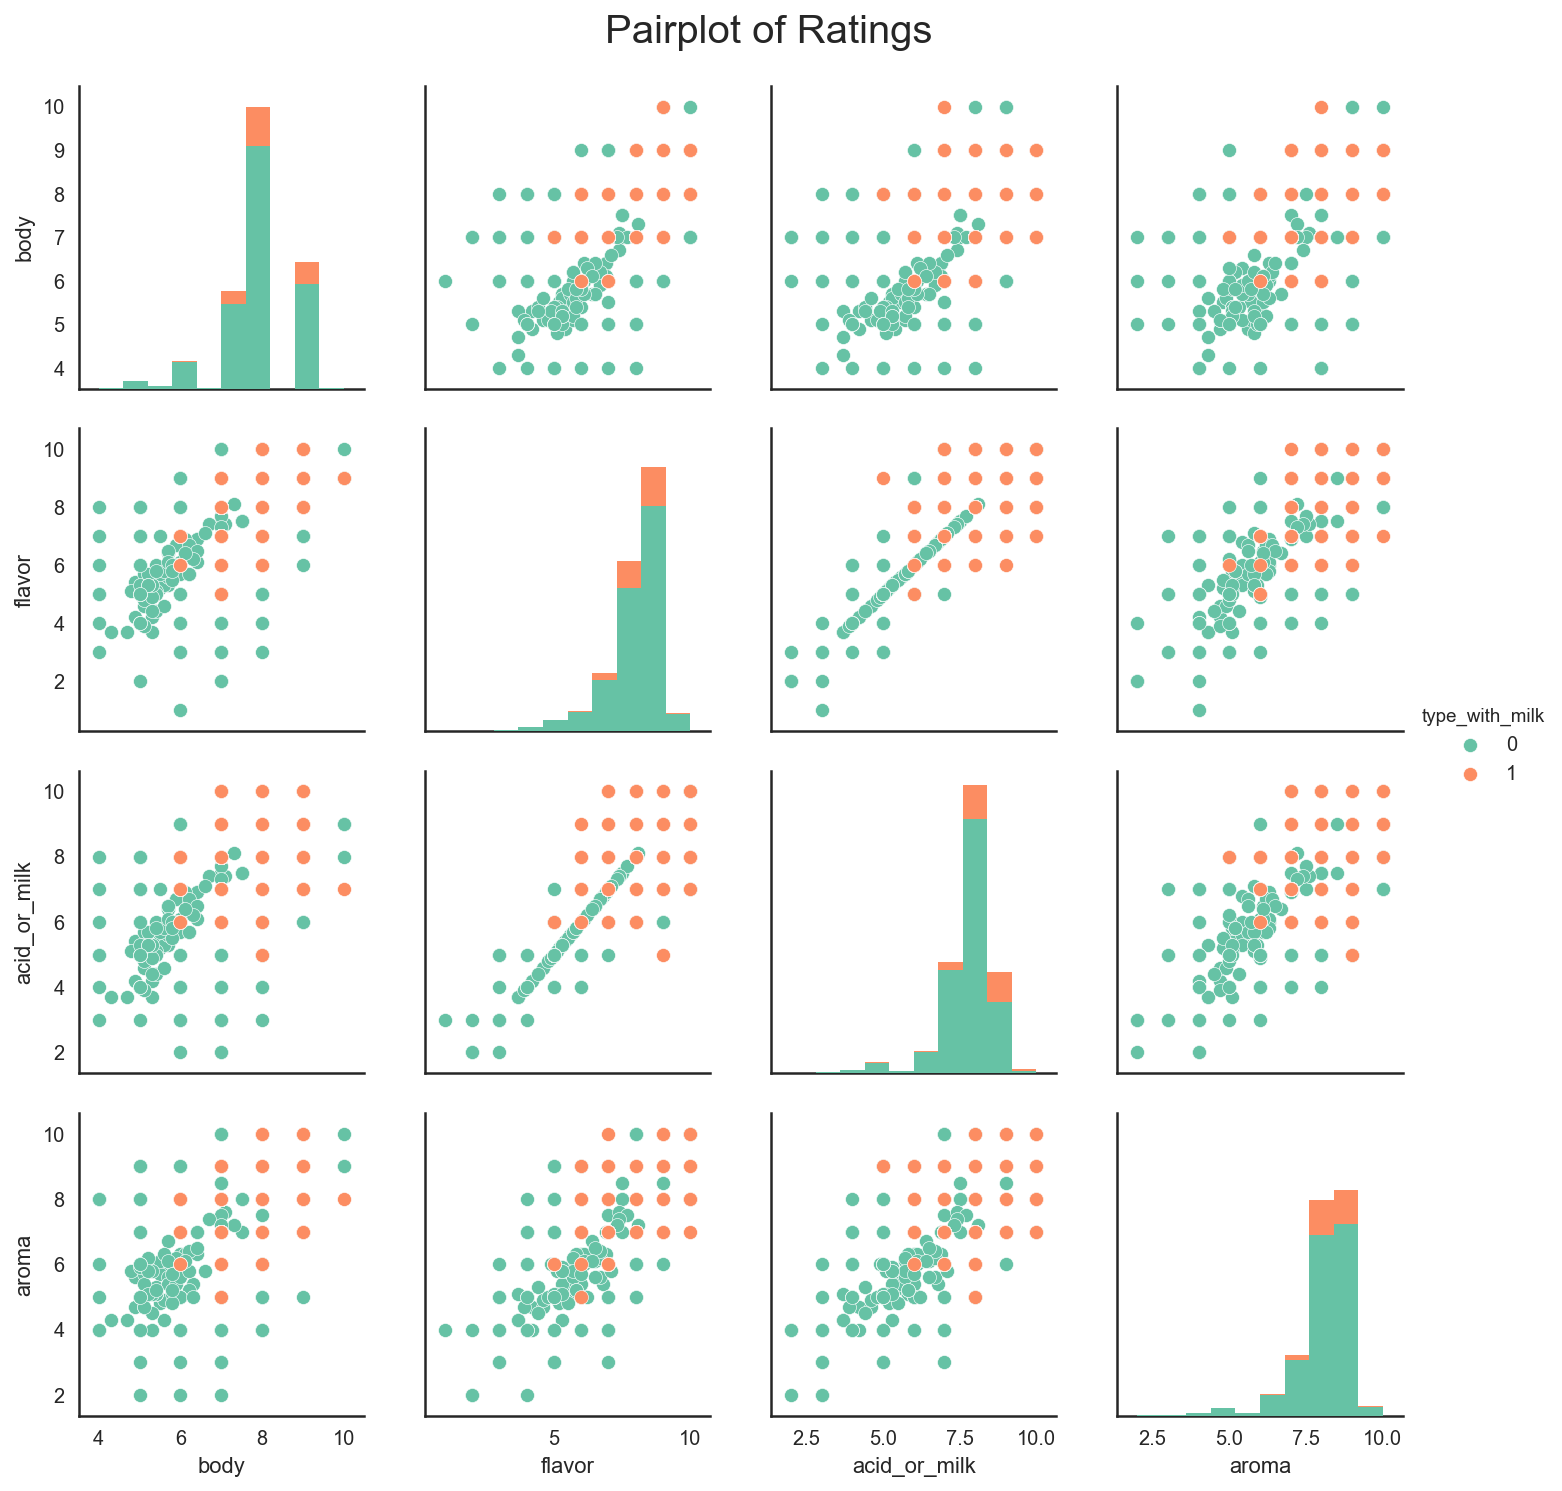

In [144]:
sns.pairplot(df[['body','flavor','acid_or_milk','aroma','type_with_milk']], 
             vars = ['body','flavor','acid_or_milk','aroma'], hue= 'type_with_milk',
             palette='Set2')
plt.suptitle("Pairplot of Ratings", fontsize = 20, y=1.03);


 - The four rating features associated with each coffee seem to be very linearly correlated with each other. That is, the higher the rating in one aspect, the higher it is in another. There is also little variance in each distribution. This will affect our recommender system in that, if we only consider these features for comparison, it will return many recommendations with very high similarity (cosine similarity close to zero).
 - Interestingly, observations `with_milk` appear to have higher ratings in each category, but not as much correlation. Possibly, these may indicate espressos or lattes, which usually have stronger flavor profiles, which are enhanced with the addition of milk. There are also fewer observations `with_milk`

#### Binary columns:  Regions and Types

In [107]:
#lists of relevant binary columns
regions = ['region_africa_arabia', 'region_caribbean', 'region_central_america', 
           'region_hawaii', 'region_asia_pacific', 'region_south_america']
types = ['type_espresso', 'type_organic', 'type_fair_trade', 
         'type_decaffeinated', 'type_pod_capsule', 'type_blend', 'type_estate','type_with_milk']

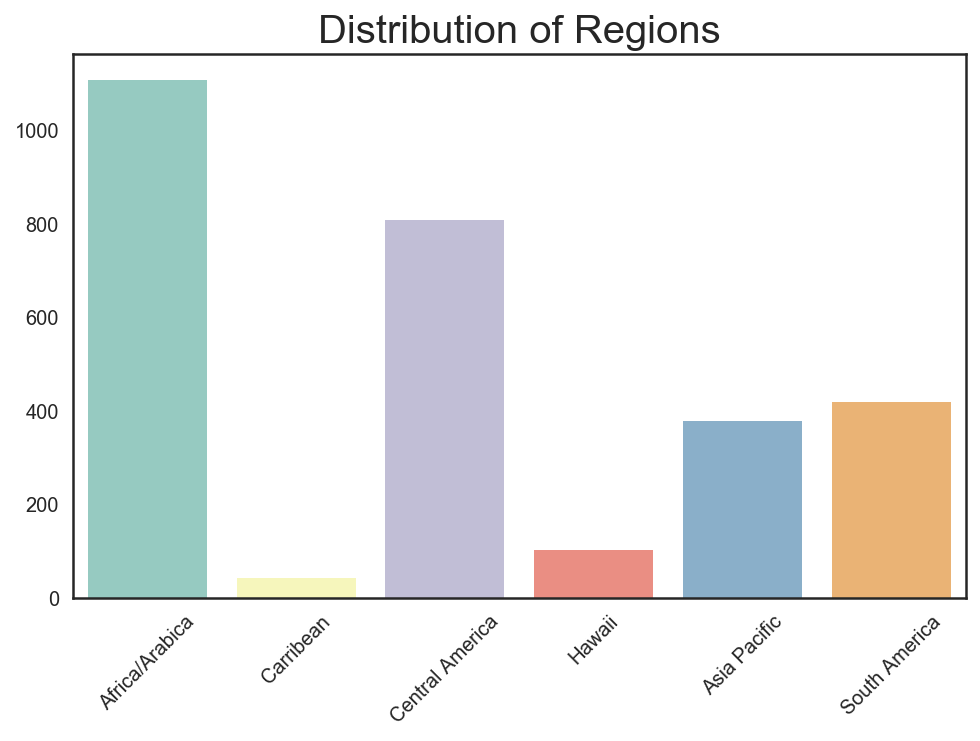

In [133]:
plt.figure(figsize=(8,5))

sns.barplot(regions, df[regions].sum(),
        palette='Set3')
plt.xticks(rotation = 45)
plt.xticks(np.arange(6), ('Africa/Arabica', 'Carribean','Central America',
                          'Hawaii','Asia Pacific','South America'),rotation='45');
plt.title("Distribution of Regions", fontsize = 20);

In [124]:
#count how many regions each coffee belongs to
df['region_sum'] = df[regions].sum(axis=1)
df['region_sum'].value_counts(normalize = True).sort_index()

0    0.422345
1    0.570902
2    0.006753
Name: region_sum, dtype: float64

 - Almost half the observations (44%) don't have a value for any `region_` columns
 - Very few have values for multiple (0.7%)
 - This could affect our recommender as it will consider coffees from the same region as more similar.
 - When the value is missing, it may consider coffees from the same region as less similar.
     - If the user considers the region of the coffee of interest as important, we will need to assume the coffee's region is listed.
 - It may be possible to parse through the `origin` column to determine which region each coffee is from, although there are many values missing from this column as well. 

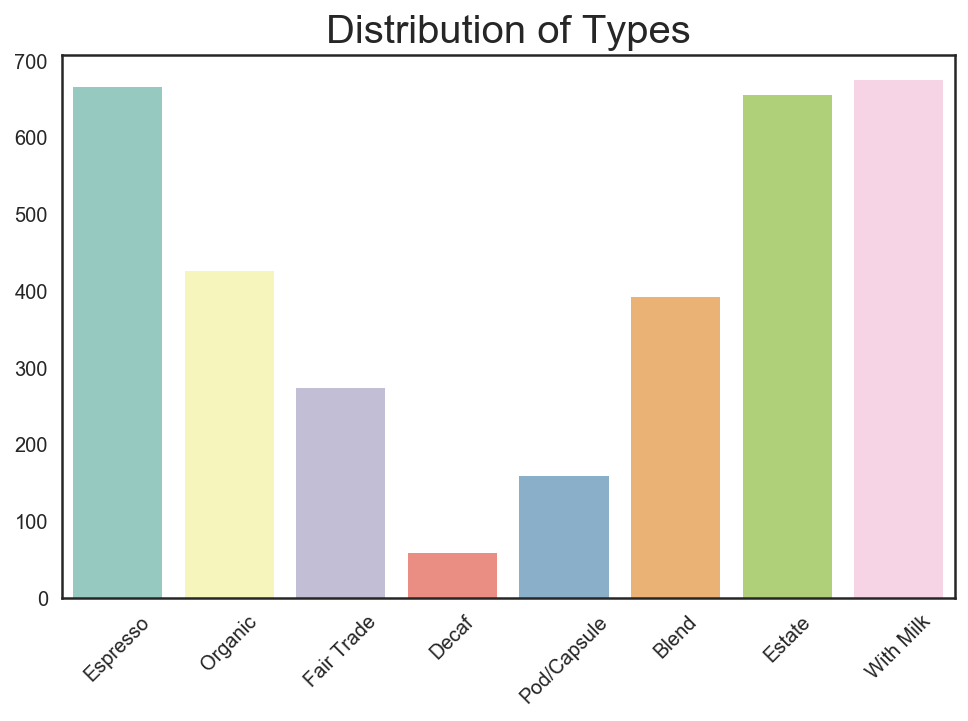

In [130]:
plt.figure(figsize=(8,5))

sns.barplot(types, df[types].sum(),
        palette='Set3')
plt.xticks(rotation = 45)
plt.xticks(np.arange(8), ('Espresso', 'Organic','Fair Trade',
                          'Decaf','Pod/Capsule','Blend','Estate','With Milk'), rotation='45')
plt.title("Distribution of Types", fontsize = 20);

In [17]:
df[types].sum(axis=1).value_counts()

0    2992
1    1532
2     460
3      80
4      10
dtype: int64

- Each coffee's type is indicated with a binary value. 
- For our purposes, we will need to assume that these values are properly assigned as we are unable to verify their completeness without more data.

#### Categorical column: Roast

In [24]:
roasts_df = pd.get_dummies(df.roast,dummy_na=True,prefix='roast')
roast_names = roasts_df.columns
roasts_df.columns = [re.sub('[ -]','_', name.lower()) for name in roast_names]
roasts_df.head()

,roast_dark,roast_light,roast_medium,roast_medium_dark,roast_medium_light,roast_very_dark,roast_nan
slug,,,,,,,
ethiopia-deri-kochoha-2,0,0,0,0,1,0,0
espresso-14,0,0,1,0,0,0,0
kenya-ruthaka-peaberry,0,0,1,0,0,0,0
ethiopia-gora-kone-sidamo,0,0,0,0,1,0,0
specialty-coffee-blend-espresso,0,0,0,0,1,0,0


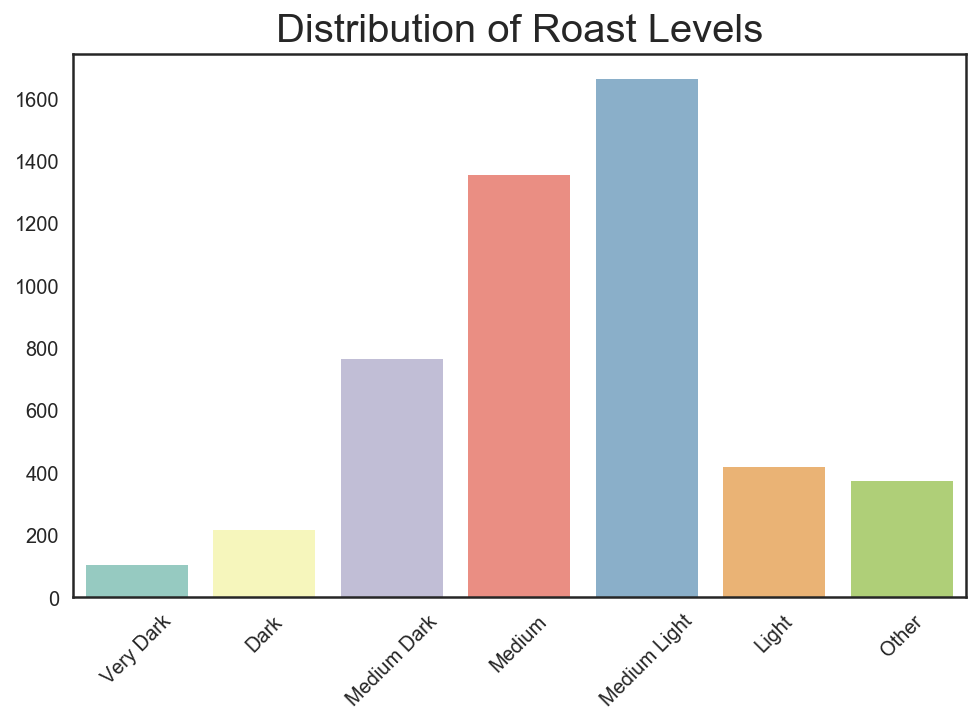

In [81]:
plt.figure(figsize=(8,5))

sns.barplot(['roast_very_dark', 'roast_dark', 'roast_medium_dark', 
         'roast_medium', 'roast_medium_light', 'roast_light', 'roast_nan'],
        roasts_df[['roast_very_dark', 'roast_dark', 'roast_medium_dark', 
         'roast_medium', 'roast_medium_light', 'roast_light', 'roast_nan']].sum(),
           palette='Set3')
plt.xticks(np.arange(7), ('Very Dark', 'Dark', 'Medium Dark', 
                          'Medium', 'Medium Light', 'Light', 'Other'),rotation='45');
plt.title("Distribution of Roast Levels", size =20);

 - If the coffee's `roast` type is unspecified, it may be due to the fact that the coffee was a blend, or was pre-bottled, or just not disclosed by the manufacturer. We will treat the unobserved `roasts` as it's own feature and call it `Other`. 

In [27]:
roasts_df.columns

Index(['roast_dark', 'roast_light', 'roast_medium', 'roast_medium_dark',
       'roast_medium_light', 'roast_very_dark', 'roast_nan'],
      dtype='object')

In [28]:
df = pd.concat([df, roasts_df], axis = 1)

## Data Dictionary

#### Exporting final DataFrames

In [37]:
id_columns = ['name', 'roaster', 'rating','review_date']
coffee_id = df[id_columns]
coffee_id.to_csv('../data/coffee_id.csv')

### Coffee_ID Data Dictionary

| Data        |    Type   |                  Description |
|-------------|-----:|-------------------------------:|
| slug        |String| Unique webpage slug for each coffee |
| name        |    String|                   Coffee's name |
| roaster     |      String|               Coffee's roaster |
| rating      |  Float (1-100)|   Coffee's overall rating |
| review_date |    Timedate (YYYY-MM-DD)   | Date of review |

In [36]:
clean_columns = ['aroma', 'acid_or_milk', 'body', 'flavor', 'type_with_milk', 'clean_text']
clean_columns.extend(list(roasts_df.columns) + regions + types)
coffee_clean = df[clean_columns]
coffee_clean.to_csv('../data/coffee_clean.csv')

### Coffee_Clean Data Dictionary


| Data   |                                   Type |     Description|
|-----------------------------------|------------:|---------------------------------:|
| aroma, body, flavor, acid_or_milk |          Float (1-10)    | Ratings for each coffee |
| type_ (9 total)                  |             Binary | Indicates type (e.g. espresso, blend, organic, etc.) |
| region_  (6 total)                |               Binary | Indicates region (e.g. Hawaii, Central America, etc.) |
| roast_ (7 total)                 | Binary | Indicates roast level |
| clean_text                        |                String | Cleaned text description of each coffee  |


In [33]:
coffee_clean.shape

(4887, 26)